# Image Caption Retrieval Task

We will work with Microsoft COCO (Common Objects in Context) data set. The data set we use for training our "Image Caption Model" is already included pretrained 10-crop VGG19 features, as described in paper ["Order-embeddings Of Images and Language"](https://arxiv.org/pdf/1511.06361.pdf):

```
Microsoft COCO dataset (Lin et al., 2014b), which has over 120,000 images, each with at least five human-annotated captions per image. This is by far the largest dataset commonly used for caption-image retrieval. We use the data splits of Karpathy & Li (2015) for training (113,287 images), validation (5000 images), and test (5000 images).
```. 

Note that this data set follows [splits](https://cs.stanford.edu/people/karpathy/deepimagesent/) produced by Andrej Karpathy, but is already formed in pairs of images (VGG19 features) - captions.


### Problem definition

* Build a model that projects captions and images in the same representation space, so that an image is close to its captions in that space, and far away from dissimilar captions and dissimilar images.
* Evaluate in retrieving (generating) captions of an image
* Evaluate in retrieving (searching) image based on text-based caption

### Instruction for downloading data set

1. Data sets (*.pickle) for training, validating, and testing our Image Caption model: 

    Download [here](https://storage.googleapis.com/trl_data/main_dataset.zip) and then locate the pickled files in folder 'data'

    This preprocessed data with VGG19 features (original data: [coco.zip](http://www.cs.toronto.edu/~vendrov/order/coco.zip)) for training our Image-Caption Model follows explanation in Assignment-3.2_PREP_DESC.ipynb. The data set consists of :

    - training set(10000 images + 50000 captions) 
    - validation set (1000 images + 5000 captions)
    - test set (1000 images + 5000 captions) 
    
2. Additional preprocessed data (*.pickle) to match ids with raw data sets: 

    Download [here](https://storage.googleapis.com/trl_data/lookup_data.zip) and then locate the pickled files in folder 'data/preprocess

3. Raw image data for visualizing retrieval task (from COCO main website) 

    * Download [2014 coco images val set](http://images.cocodataset.org/zips/val2014.zip) (6 GB) 
    * Extract and then locate images in folder 'data/val2014'

In [1]:
from __future__ import print_function

import os
import sys
import numpy as np
import pandas as pd
from collections import OrderedDict
import datasource

You will need to create the following folders and located data set per above instruction

In [2]:
DATA_PATH = 'data'
PREP_DATA = 'data/preprocess'
IMAGE_DATA = 'data/val2014'
EMBEDDING_PATH = 'embedding'
MODEL_PATH = 'model'

In [3]:
import _pickle as cPickle

# reading file in pickle format
def readPickle(pickleFilename):
    f = open(pickleFilename, 'rb')
    obj = cPickle.load(f)
    f.close()
    return obj

def savePickle(dataToWrite,pickleFilename):
    f = open(pickleFilename, 'wb')
    cPickle.dump(dataToWrite, f)
    f.close()

In [4]:
def build_dictionary(text):

    wordcount = OrderedDict()
    for cc in text:
        words = cc.split()
        for w in words:
            if w not in wordcount:
                wordcount[w] = 0
            wordcount[w] += 1
    words = list(wordcount.keys())
    freqs = list(wordcount.values())
    sorted_idx = np.argsort(freqs)[::-1]
    

    worddict = OrderedDict()
    worddict['<pad>'] = 0
    worddict['<unk>'] = 1
    for idx, sidx in enumerate(sorted_idx):
        worddict[words[sidx]] = idx+2  # 0: <pad>, 1: <unk>
    

    return worddict

### 1. Reading preprocessed data (includes VGG19 features)

### Important! 

* You need to have same version of python to unpickle these files. Otherwise, you will need to preprocess the data by yourself as explained in Assignment-3.2_PREP_DESC.ipynb

In [5]:
#PYTHON VERSION
print(sys.version)

3.5.4 | packaged by conda-forge | (default, Aug 10 2017, 01:38:41) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


In [6]:
train_data = readPickle(os.path.join(DATA_PATH, 'train_data'))

In [7]:
val_data = readPickle(os.path.join(DATA_PATH, 'val_data'))

In [8]:
test_data = readPickle(os.path.join(DATA_PATH, 'test_data'))

Data sets are in dictionary format of two (2) features: Images and Caption with proportion 1:5 (1 image with 5 human annotations). 

In [9]:
train_data.keys()

dict_keys(['caps', 'ims'])

Image data is already in the format of VGG19 features. 

In [10]:
train_data['ims'][0]

array([0.00495117, 0.        , 0.        , ..., 0.        , 0.00079085,
       0.01148911], dtype=float32)

Caption data is represented as sentence description of image. Each image has 5 captions or text desciption. 

In [11]:
train_data['caps'][0]

b'a woman wearing a net on her head cutting a cake'

### 2. Reading additional preprocessed data to look-up matched ids of raw COCO dataset

* Dictionary data of captions (caption-id, caption-text)
* Dictionary data of images (image-id, image-text)
* Pairs of caption-id and image-id
* Matched caption-ids between preprocessed validation data and raw original validation set 

In [12]:
cap_val_data = readPickle(os.path.join(PREP_DATA, 'cap_val_data'))

In [13]:
list(cap_val_data.items())[:3]

[(37, 'A bicycle replica with a clock as the front wheel.'),
 (38, 'A black Honda motorcycle parked in front of a garage.'),
 (49, 'A room with blue walls and a white sink and door.')]

In [14]:
img_val_data = readPickle(os.path.join(PREP_DATA, 'img_val_data'))

In [15]:
list(img_val_data.items())[:3]

[(391895, 'COCO_val2014_000000391895.jpg'),
 (522418, 'COCO_val2014_000000522418.jpg'),
 (184613, 'COCO_val2014_000000184613.jpg')]

In [16]:
cap_imgs = readPickle(os.path.join(PREP_DATA, 'cap_imgs'))

In [17]:
cap_imgs[:5]

[(37, 203564), (38, 179765), (49, 322141), (89, 16977), (98, 106140)]

In [18]:
val_matched_data = readPickle(os.path.join(PREP_DATA, 'val_matched_data'))

In [19]:
val_matched_data[:3]
# caption-id in original validation set (cap_val_data) , caption-id in preprocessed validation set (val_data['caps]),
# caption-text

[(5835, 1260, 'a dirt bike rider doing a stunt jump in the air'),
 (8427, 1261, 'a man riding a dirt bike becomes airborne'),
 (10986, 1262, 'a motorcyclist is in mid air hanging on to the handlebars')]

### 3. Build vocabulary index 

In [20]:
all_captions = []
all_captions = train_data['caps'] + val_data['caps'] + test_data['caps']

In [21]:
# decode bytes to string format
caps = []
for w in all_captions:
    caps.append(w.decode())

In [22]:
words_indices = build_dictionary(caps)
print ('Dictionary size: ' + str(len(words_indices)))

Dictionary size: 10341


In [23]:
list(words_indices.items())[:5]

[('<pad>', 0), ('<unk>', 1), ('a', 2), ('on', 3), ('of', 4)]

In [24]:
indices_words = dict((v,k) for (k,v) in words_indices.items())

In [25]:
list(indices_words.items())[:5]

[(0, '<pad>'), (1, '<unk>'), (2, 'a'), (3, 'on'), (4, 'of')]

In [26]:
# uncomment to store file
#savePickle(words_indices, os.path.join(DATA_PATH, 'words_indeces'))

In [27]:
# uncomment to store file
#savePickle(indices_words, os.path.join(DATA_PATH, 'indices_words'))

### 4. Build Image - Caption Model

In [28]:
from keras.layers import Embedding,GRU,LSTM,concatenate,Reshape,add,dot
from keras.callbacks import EarlyStopping, Callback
from keras.layers import Input, Dense
from keras.layers.core import Lambda, Masking
from keras.models import Model

/home/tita/miniconda3/envs/tfenv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Caption model

In [29]:
# input for caption and caption-noise model
caption_input = Input(shape=(50,), name='caption_input')
noise_input = Input(shape=(50,), name='noise_input')

In [30]:
# layers for caption and caption-noise model
caption_embedding = Embedding(output_dim=300, input_dim=len(words_indices), input_length=50, name='cap_word_embedding')
caption_gru = GRU(1024, return_sequences=False, name='cap_encode_gru')

In [31]:
print ("Text model loading")
# this returns a tensor of caption and noise encodings

caption_encoded = caption_gru(caption_embedding(caption_input))
noise_encoded = caption_gru(caption_embedding(noise_input))

Text model loading


### Image model

In [32]:
# input for image model
image_input = Input(shape=(4096,), name='image_input')

In [33]:
# layer for image model
image_dense = Dense(1024,name='img_encode_dense')

In [34]:
print ("Image model loading")
# this returns a tensor of image embeddings
image_encoded = image_dense(image_input)

Image model loading


### Join model

In [35]:
positive_pair = dot([image_encoded, caption_encoded], axes = 1, normalize=False)
negative_pair = dot([image_encoded, noise_encoded], axes = 1, normalize=False)

In [36]:
# merge pairs
output_merged = concatenate([positive_pair, negative_pair],axis=-1,name='output_merged')
output_merged.shape

TensorShape([Dimension(None), Dimension(2)])

### Main model for training stage

In [37]:
print ("loading the training model")
training_model = Model(inputs=[caption_input, noise_input, image_input], outputs=output_merged)

loading the training model


### Retrieval model

In [38]:
print ("loading sub-models for retrieving encodings")
caption_model = Model(inputs=caption_input, outputs=caption_encoded)
image_model = Model(inputs=image_input, outputs=image_encoded)

loading sub-models for retrieving encodings


### Loss function

We define our loss function as a loss for maximizing the margin between a positive and
negative example.  If we call $p_i$ the score of the positive pair of the $i$-th example, and $n_i$ the score of the negative pair of that example, the loss is:

\begin{equation*}
loss = \sum_i{max(0, 1 -p_i + n_i)}
\end{equation*}

In [39]:
from keras import backend as K
def max_margin_loss(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    
    return K.sum(K.maximum(0., 1. - positive + negative))

#### Accuracy metric for max-margin loss
How many times did the positive pair effectively get a higher value than the negative pair?

In [40]:
def accuracy(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    
    return K.mean(positive > negative)

### Compile model

In [41]:
print ("compiling the training model")
training_model.compile(optimizer='adam', loss=max_margin_loss, metrics=[accuracy])

compiling the training model


### 5. Data preparation for training the model

* adjust the length of captions into fixed maximum length (50 words)
* sampling caption for each image, while shuffling the image data
* encode captions into integer format based on look-up vocabulary index

In [42]:
def prepare_caption(indices, caption_data):
    caption_seqs = []
    for i in indices:
        cap = caption_data[i]
        
        int_cap = np.array([words_indices[w] if w in words_indices else 1 for w in cap.split()])
        len_caps = int_cap.shape[0]
        int_cap = int_cap.reshape([len_caps,])
        if len_caps > 50:
            caption_seqs.append(int_cap[:50])
        else:
            padding = np.array([0]*(50-len_caps))
            padded_seq = np.concatenate((int_cap,padding),axis = 0)
            caption_seqs.append(padded_seq)
      
    return np.array(caption_seqs)

In [43]:
import random

In [44]:
def sampling_img_cap(data):
    
    idx = 0
    img_ids = []
    cap_ids = []

    rand_im = np.random.permutation(len(data['ims']))
    
    while idx < len(rand_im):
        img_id = rand_im[idx]
        cap_id = img_id * 5 + random.randrange(5)
        img_ids.append(img_id)
        cap_ids.append(cap_id)
        idx += 1
        
    return rand_im, img_ids, cap_ids

In [45]:
train_rand_im, train_img_ids, train_cap_ids = sampling_img_cap(train_data)

In [46]:
val_rand_im, val_img_ids, val_cap_ids = sampling_img_cap(val_data)

In [47]:
test_rand_im, test_img_ids, test_cap_ids = sampling_img_cap(test_data)

Encoded training set:

In [48]:
train_data['caps'][:3]

[b'a woman wearing a net on her head cutting a cake',
 b'a woman cutting a large white sheet cake',
 b'a woman wearing a hair net cutting a large sheet cake']

In [49]:
train_caps = []
for cap in train_data['caps']:
    train_caps.append(cap.decode())

In [50]:
train_caps[:3]

['a woman wearing a net on her head cutting a cake',
 'a woman cutting a large white sheet cake',
 'a woman wearing a hair net cutting a large sheet cake']

In [51]:
x_cap = prepare_caption(train_cap_ids, train_caps)
x_im = train_data['ims'][np.array(train_img_ids)]

In [52]:
x_cap.shape

(10000, 50)

In [53]:
x_im.shape

(10000, 4096)

Encoded validation set

In [54]:
val_caps = []
for cap in val_data['caps']:
    val_caps.append(cap.decode())

In [55]:
x_val_cap = prepare_caption(val_cap_ids, val_caps)
x_val_im = val_data['ims'][np.array(val_img_ids)]

In [56]:
x_val_cap.shape

(1000, 50)

In [57]:
x_val_im.shape

(1000, 4096)

Encoded test set

In [58]:
test_caps = []
for cap in test_data['caps']:
    test_caps.append(cap.decode())

In [59]:
x_test_cap = prepare_caption(test_cap_ids, test_caps)
x_test_im = test_data['ims'][np.array(test_img_ids)]

In [60]:
x_test_cap.shape

(1000, 50)

In [61]:
x_test_im.shape

(1000, 4096)

### Creating noise set and dummy labels

In [62]:
train_noise = np.copy(x_cap)
train_noise.shape

(10000, 50)

In [63]:
val_noise = np.copy(x_val_cap)
val_noise.shape

(1000, 50)

In [64]:
y_train_labels = np.zeros(shape=(x_im.shape[0], 1))
y_val_labels = np.zeros(shape=(x_val_im.shape[0], 1))

In [65]:
y_train_labels.shape

(10000, 1)

In [66]:
y_val_labels.shape

(1000, 1)

### 6. Training model

In [67]:
X_train = [x_cap, train_noise, x_im]
Y_train = y_train_labels
X_valid = [x_val_cap, val_noise, x_val_im]
Y_valid = y_val_labels

In [70]:
for epoch in range(20):
    np.random.shuffle(train_noise)
    np.random.shuffle(val_noise) 
    training_model.fit(X_train, Y_train, validation_data=[X_valid, Y_valid], \
                       epochs=1, batch_size=128)


Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 1915s 192ms/step - loss: 127.8498 - accuracy: 0.4581 - val_loss: 125.5036 - val_accuracy: 0.4820
Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 2548s 255ms/step - loss: 127.8305 - accuracy: 0.4246 - val_loss: 125.5040 - val_accuracy: 0.3530
Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 3099s 310ms/step - loss: 128.4872 - accuracy: 0.4580 - val_loss: 125.1218 - val_accuracy: 0.4840
Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 2833s 283ms/step - loss: 124.4600 - accuracy: 0.6537 - val_loss: 61.1495 - val_accuracy: 0.8060
Train on 10000 samples, validate on 1000 samples
Epoch 1/1
10000/10000 [==============================] - 3817s 382ms/step - loss: 44.7268 - accuracy: 0.8577 - val_loss: 35.5856 - val_accur

### 7. Storing models and weight parameters

In [71]:
# Save model
training_model.save(os.path.join(MODEL_PATH,'trained_image_caption_model.h5'))

In [72]:
# Save weight parameters
training_model.save_weights(os.path.join(MODEL_PATH, 'weights_trained_image_caption.hdf5'))

### 8. Encoding caption and image (for retrieval task)

In [73]:
val_cap_enc = caption_model.predict(x_val_cap)
val_img_enc = image_model.predict(x_val_im)

In [74]:
#UNCOMMENT TO STORE FILES
#savePickle(val_cap_enc, os.path.join(DATA_PATH, 'val_cap_enc'))
#savePickle(val_img_enc, os.path.join(DATA_PATH, 'val_img_enc'))

In [75]:
# Save model for encoding caption and image
caption_model.save(os.path.join(MODEL_PATH,'caption_model.h5'))
image_model.save(os.path.join(MODEL_PATH,'image_model.h5'))

### 7. Captioning image

In [76]:
def prepare_test_caption(caption_data):
    caption_seqs = []
    for i in range(len(caption_data)):
        cap = caption_data[i]
        
        int_cap = np.array([words_indices[w] if w in words_indices else 1 for w in cap.split()])
        len_caps = int_cap.shape[0]
        int_cap = int_cap.reshape([len_caps,])
        if len_caps > 50:
            caption_seqs.append(int_cap[:50])
        else:
            padding = np.array([0]*(50-len_caps))
            padded_seq = np.concatenate((int_cap,padding),axis = 0)
            caption_seqs.append(padded_seq)
      
    return np.array(caption_seqs)

In [77]:
import re

def get_img_id(filename):
    # create and compile a regex pattern
    pattern = re.compile(r"_([0-9]+)\.[^\.]+$")
    
    imgid = pattern.search(filename).group(1)
    
    return int(imgid)

#### Filepath of image as a query for generating caption

In [78]:
img_val_data[292931]

'COCO_val2014_000000292931.jpg'

#### Ground truth caption of the corresponding image

In [94]:
val_data['caps'][4665]

b'two orange and white kittens sleeping in a pot'

#### Original image as query

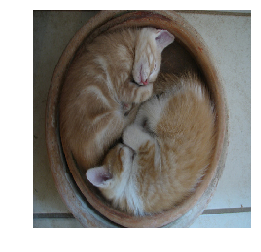

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
img = image.load_img(os.path.join(IMAGE_DATA,img_val_data[292931]), target_size=(224,224))
plt.imshow(img)
plt.axis("off")
plt.show()

#### Function to match data between validation set with VGG features and raw data set (for visualization)

In [80]:
# return caption ids from raw data
def list_raw_cap_id(id_of_img_file):
    cap_id_raw = []
    for (capid,imgid) in cap_imgs:
        if imgid == id_of_img_file:
            cap_id_raw.append((capid,imgid))
    
    cap_id_raw = np.array(cap_id_raw)
    return cap_id_raw[:,0]
    

In [81]:
# return matched caption ids from preprocessed data
# based on retrieved caption ids from raw data set
def list_capid(cap_ids):
    cap_id_prep = []
    for (id1,id2,txt) in val_matched_data:
        if id1 in list(cap_ids):
            cap_id_prep.append((id1, id2, txt))
    cap_id_prep = np.array(cap_id_prep)
    return cap_id_prep

#### Function to transform integer sequence of predicted caption to its textual format

In [83]:
def transform_int_to_words(int_seq, indices_words):
    
    word_seq = []
    for int_w in int_seq:
        word = indices_words[int_w]
    
        if word != '<pad>':
            word_seq.append(word)
    
    text = ' '.join(word_seq)
    
    return text

#### Function to generate caption

In [86]:
def generate_caption(image_filename, n=10):
    
    img_id = get_img_id(image_filename)
    cap_id_raw = list_raw_cap_id(img_id)
    cap_id_prep = list_capid(cap_id_raw)
    cap_ids = list(cap_id_prep[:,1])
  
    # Look-up the encoding of image in val_data['ims]
    cap_id_of_im = int(int(cap_ids[0]) / 5)
    
    
    image_vgg_feat = val_data['ims'][cap_id_of_im]
    image_vgg_feat = image_vgg_feat.reshape([1,-1])
    
    image_enc = image_model.predict(image_vgg_feat[0:1])
  
    # compute score of all captions in the dataset
    scores = np.dot(val_cap_enc, image_enc.T).flatten()
    
    # compute indices of n best captions
    indices = np.argpartition(scores, -n)[-n:]
    indices = indices[np.argsort(scores[indices])]
    
    print(indices)
    
    # display them
    for i in [int(x) for x in reversed(indices)]:
        int_seq = x_val_cap[i]
        txt = transform_int_to_words(int_seq, indices_words)
        print(" ")
        print("score: %s" %scores[i])
        print(txt)
        print("==========================================")


In [87]:
generate_caption(img_val_data[292931])

[566 221 407 756 610 111 157 416 838 667]
 
score: 11.241987
a white cat that has yellow eyes looking straight ahead
 
score: 11.097305
an orange tabby cat is curled up fast asleep on the top of a sofa cushion
 
score: 11.013317
white cat curled up asleep in a blanketed chair
 
score: 10.958149
a cat is drinking something from a glass
 
score: 10.932552
a brown striped cat looks at the camera
 
score: 10.927643
a grey and white cat sitting next to keyboard and computer monitor
 
score: 10.908761
two cats sitting on top of a pair of shoes
 
score: 10.889954
there is a bear on a telephone book sitting in a highchair
 
score: 10.87727
cat sitting on a maroon couch behind a coffee table
 
score: 10.827053
a white cat sitting on the floor next to a feeding dish and a mat


### 8. Searching image

#### Function to match data between validation set with VGG features and raw data set

In [398]:
def match_raw_images(val_im_ids, scores):
    
    val_cap_ids = []
    raw_cap_ids = []
    raw_im_ids = []
    raw_capim_ids = []
    
    raw_cap_scores = []
    raw_im_scores = []
   
    #
    for i, imgid in enumerate(val_im_ids):
        #caption id = factor of 5 from image id
        capid = int(imgid/5) + np.remainder(imgid,5)
        val_cap_ids.append(capid)
       
    for j, capid in enumerate(val_cap_ids):
        for (id1,id2,txt) in val_matched_data:
            if capid == id2:
                if id1 not in raw_cap_ids:
                    raw_cap_ids.append(id1)
                    raw_cap_scores.append(scores[j])
    
    for k, cid in enumerate(raw_cap_ids):
        for (capid,imid) in cap_imgs:
            if cid == capid:
                if imid not in raw_im_ids:
                    raw_im_ids.append(imid)
                    raw_capim_ids.append(capid)
                    raw_im_scores.append(raw_cap_scores[k])
    
    return val_cap_ids, raw_cap_ids,raw_im_ids, raw_capim_ids, raw_im_scores

#### Main function to search image from text caption query

In [399]:
def search_image(text_caption, n=10):
    
    int_caption = prepare_test_caption([text_caption])
    
    caption_enc =  caption_model.predict(int_caption[0:1])
    scores = np.dot(val_img_enc, caption_enc.T).flatten()
    
    # this sorted index (top-10) is index of images in validation set 
    indices = np.argpartition(scores, -n)[-n:]
    indices = indices[np.argsort(scores[indices])]
    
    sorted_val_img_ids = list(reversed(indices))
    sorted_scores = [scores[idx] for idx in sorted_val_img_ids]
    
      
    val_cap_ids, raw_cap_ids,raw_im_ids, raw_capim_ids, raw_im_scores = match_raw_images \
    (sorted_val_img_ids, sorted_scores)
    
  
    
    for i, (img_id, cap_id) in enumerate(zip(raw_im_ids, raw_capim_ids)):
        print("score: %s" %raw_im_scores[i])
        #print(img_val_data[img_id])
      
        plt.clf()
        img = image.load_img(os.path.join(IMAGE_DATA,img_val_data[img_id]), \
                             target_size=(224,224))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        print("original caption: %s" %cap_val_data[cap_id])
        print("==========================================")
       
            

In [400]:
text = 'two giraffes standing near trees'

score: 12.989643


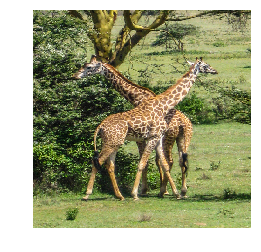

original caption: Two giraffes crossing paths on a green and grassy field.
score: 11.829571


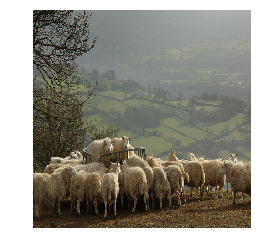

original caption: A group of white sheep in grassy area next to trees.
score: 11.660101


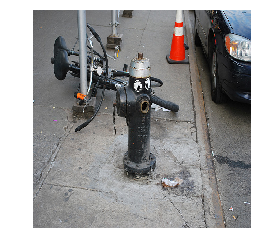

original caption: A fire hydrant with a pair of eye stickers making a face on it.
score: 11.117626


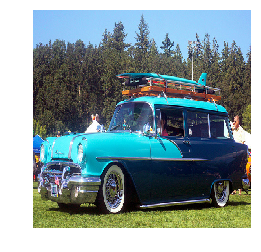

original caption: An old station wagon with a surfboard on top of it.
score: 11.112984


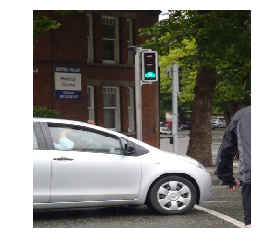

original caption: a car is stopped in the street for people to cross
score: 11.051908


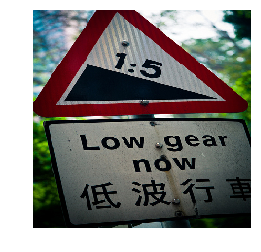

original caption: Closeup of two street signs with various languages on them.
score: 10.635056


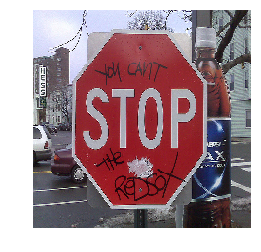

original caption: A stop sign with words written on it with a black marker.


In [401]:
search_image(text)